In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, pacf

from scipy import signal
from scipy import stats

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit


from new_stations import *
from time_series_model import *


In [2]:
data, weather = load_data()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [3]:
data = feature_addition(data)

In [4]:
city = model_city(data,2)

In [5]:
#cdf = current month df
#ndf = next month df
cdf, ndf = month_sep(city, 2017, 9)

In [6]:
#proposed stations
ps = new_stn_coords(cdf, ndf)
ps

[249.0, 234.0, 205.0, 238.0, 274.0, 215.0, 152.0, 153.0, 251.0]

In [7]:
df1 = cdf

In [8]:
df2 = ndf

In [9]:
qtr = days_for_ts(city, cdf,3)

/Users/michellehoang/galvanize/Capstone_Project/time_series_model.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  tsdf['days'] = 1
/Users/michellehoang/galvanize/Capstone_Project/time_series_model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  tsdf['days'][tsdf.month == mon] = tsdf.day * mult
/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:8672: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_i

In [10]:
def month_sep(df, year, month):
    #current month
    cdf = df[(df.year == year) & (df.month == month)]
    #next month
    ndf = df[(df.year == year) & (df.month == (month+1))]
    return cdf, ndf


In [11]:
def days_count(df, station_id):
    tsplt = df['days'][df.end_station_id == station_id].value_counts().reset_index()
    tsplt = np.array(tsplt)
    tsplt = tsplt[np.argsort(tsplt[:,0])]
    return tsplt

In [12]:
def days_for_ts(df, cdf, hist=3):
    cm = cdf.month.unique()[0]
    cy = cdf.year.unique()[0]

    #create a new dataframe
    #which includes the current month's data
    #as well as data from the 2 previous months
    tsdf = df[(df.year == cy)&(df.month <=cm) & (df.month>=cm-hist)]


    #create a new column called days and give it an arbitrary number
    #we will adjust it later
    tsdf['days'] = 1


    #sort the months by ascending order
    months = np.sort(tsdf.month.unique())


    #create a multiplier based on months
    # 3x for current month
    # 2x for previous month
    # 1x for months ago
    for idx, mon in enumerate(months):
        mult = idx+1
        #scale the days with the multiplier
        #range from 1-93
        tsdf['days'][tsdf.month == mon] = tsdf.day * mult
    return tsdf

In [13]:
def split(df, year, month, hist=3):
    #current month
    cdf = df[(df.year == year) & (df.month == month)]
    #next month
    ndf = df[(df.year == year) & (df.month == (month+1))]    

    #create a new dataframe
    #which includes the current month's data
    #as well as data from the 2 previous months
    tsdf = df[(df.year == cy)&(df.month <=cm) & (df.month>=cm-hist)]


    #create a new column called days and give it an arbitrary number
    #we will adjust it later
    tsdf['days'] = 1


    #sort the months by ascending order
    months = np.sort(tsdf.month.unique())


    #create a multiplier based on months
    # 3x for current month
    # 2x for previous month
    # 1x for months ago
    for idx, mon in enumerate(months):
        mult = idx+1
        #scale the days with the multiplier
        #range from 1-93
        tsdf['days'][tsdf.month == mon] = tsdf.day * mult
    return tsdf

In [14]:
def knn_proposed_stn(qtr, df1, df2, proposed_stn, num_neighbors = 3):
    
    #all coordinates for each trip
    coordinates = np.array(df1[['start_station_longitude', 'start_station_latitude']])
    #unique coords in df1
    unique_coords = np.unique(coordinates, axis = 0)
    #get the id and coords for current month
    id_coord_df1 = stn_coords(df1)
    id_coord_df2 = stn_coords(df2)
    knn_dict = {}
    for p in proposed_stn:
        dist = euclidean_distance(id_coord_df2.get(p), unique_coords)
        potential_neighbors = unique_coords[np.argsort(dist)]
        neighbors = np.array([0,0])
        for pot in potential_neighbors:
            sid = qtr.start_station_id[(qtr.start_station_longitude==pot[0])&(qtr.start_station_latitude==pot[1])].unique()[0]
            if len(qtr.days[qtr.start_station_id==sid].unique())>10:
                neighbors = np.vstack((neighbors, pot))
        neighbors = neighbors[1:num_neighbors+1]


    #         k = df.start_station_id[(df.start_station_longitude == id_coord_df2.get(p)[0]) &(df.start_station_latitude == id_coord_df2.get(p)[1])].iloc[0]
        v = []
        for i in range(num_neighbors):
            knn_id = qtr.start_station_id[(qtr.start_station_longitude == neighbors[i][0]) &(qtr.start_station_latitude == neighbors[i][1])].iloc[0]
            v.append(int(knn_id))
        knn_dict[int(p)] = v
    return knn_dict, id_coord_df1, id_coord_df2

In [15]:
#neighbors for each proposed location
#id and coordinate combo for each station
neighbors, id_coord1, id_coord2= knn_proposed_stn(qtr, cdf, ndf, ps)

In [16]:
neighbors

{249: [248, 240, 167],
 234: [227, 226, 224],
 205: [210, 204, 175],
 238: [246, 244, 245],
 274: [241, 248, 247],
 215: [177, 178, 176],
 152: [150, 151, 149],
 153: [154, 156, 157],
 251: [246, 244, 245]}

In [17]:
def plt_neighbors(cdf, neighbors, coords):
    for k, v in neighbors.items(): 
        print("The origin station is {}.".format(k))
        n1 = int(neighbors.get(k)[0])
        n2 = int(neighbors.get(k)[1])
        n3 = int(neighbors.get(k)[2])
        print("The 3 closest stations are: {}, {}, {}".format(n1,n2,n3))
        plt.figure(figsize = (10,10))
        
        
#         #lims for SF
#         ll,rr = -122.50, -122.36
#         bb = 37.73
        #lims for OAK
        ll,rr = -122.33, -122.19
        bb = 37.76
        plt.xlim(ll,rr)
        plt.ylim(bb, bb+(rr-ll))
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.title("Map of Ford GoBike stations in San Francisco")
        plt.scatter(cdf.end_station_longitude, cdf.end_station_latitude, s=1, c=('r'))
        plt.scatter(coords.get(k)[0], coords.get(k)[1], s=50, marker='x', c=('b'))

        for st in neighbors.get(k):
            plt.scatter(coords.get(st)[0],coords.get(st)[1], s= 20, c='g')
        plt.show()



In [18]:
# for st in neighbors.get(203):
#     plt.scatter(id_coord2.get(st)[0],id_coord2.get(st)[1], s= 10, c='g')

The origin station is 249.
The 3 closest stations are: 248, 240, 167


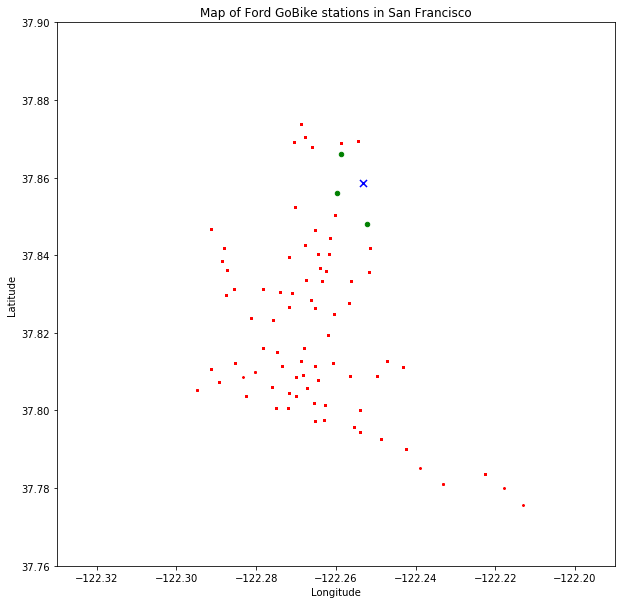

The origin station is 234.
The 3 closest stations are: 227, 226, 224


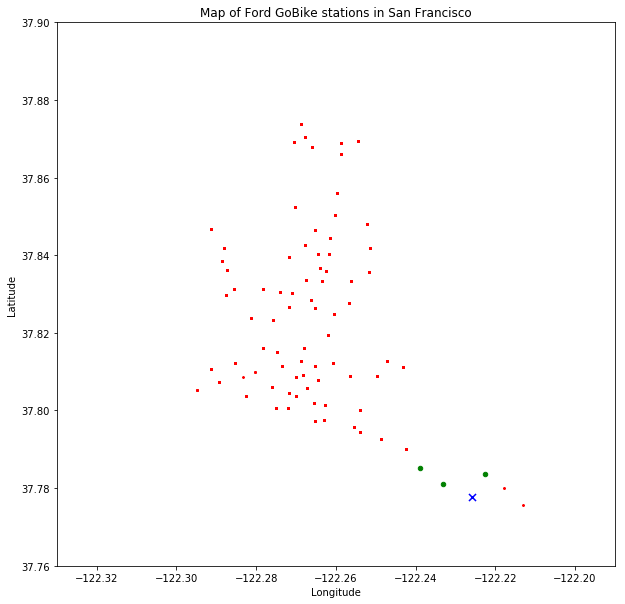

The origin station is 205.
The 3 closest stations are: 210, 204, 175


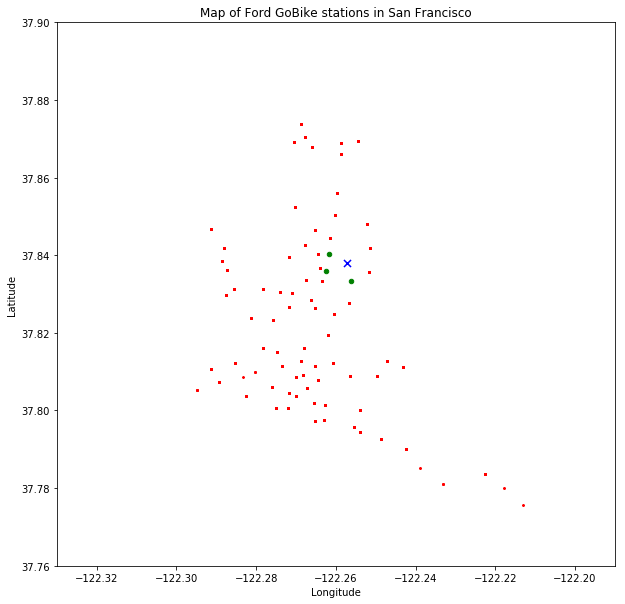

The origin station is 238.
The 3 closest stations are: 246, 244, 245


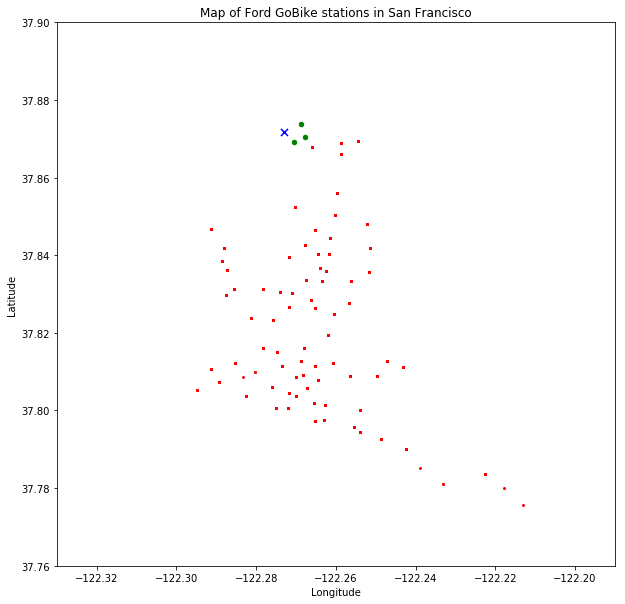

The origin station is 274.
The 3 closest stations are: 241, 248, 247


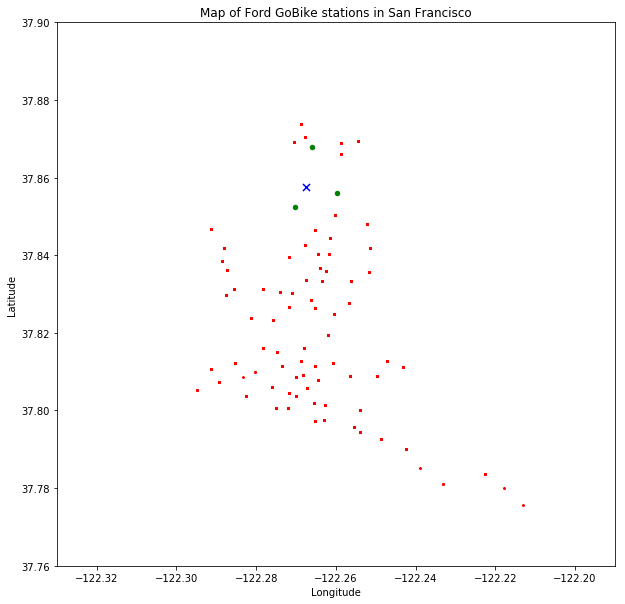

The origin station is 215.
The 3 closest stations are: 177, 178, 176


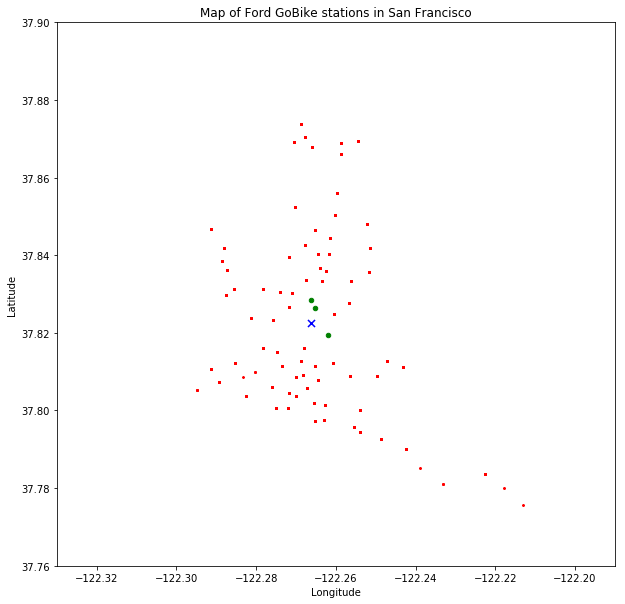

The origin station is 152.
The 3 closest stations are: 150, 151, 149


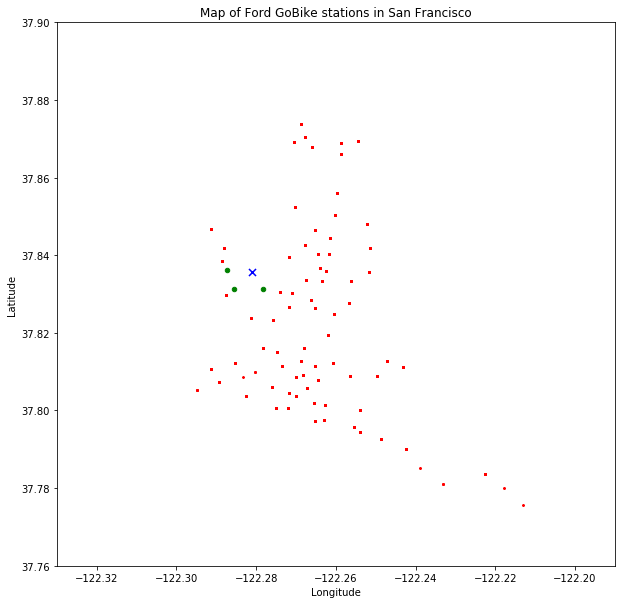

The origin station is 153.
The 3 closest stations are: 154, 156, 157


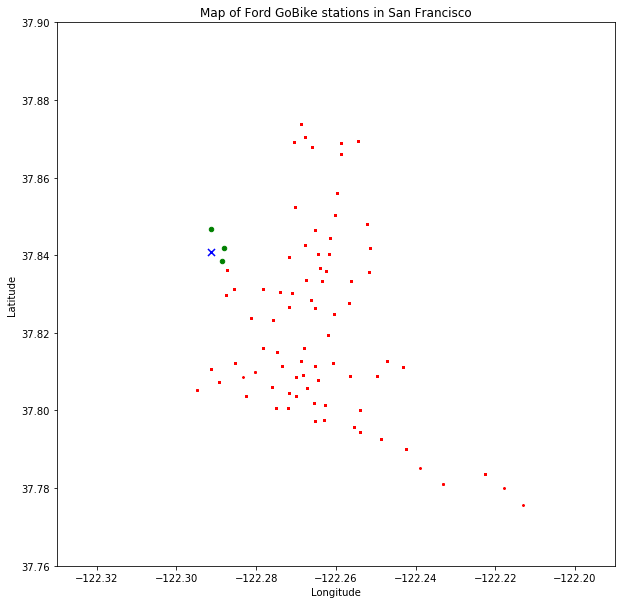

The origin station is 251.
The 3 closest stations are: 246, 244, 245


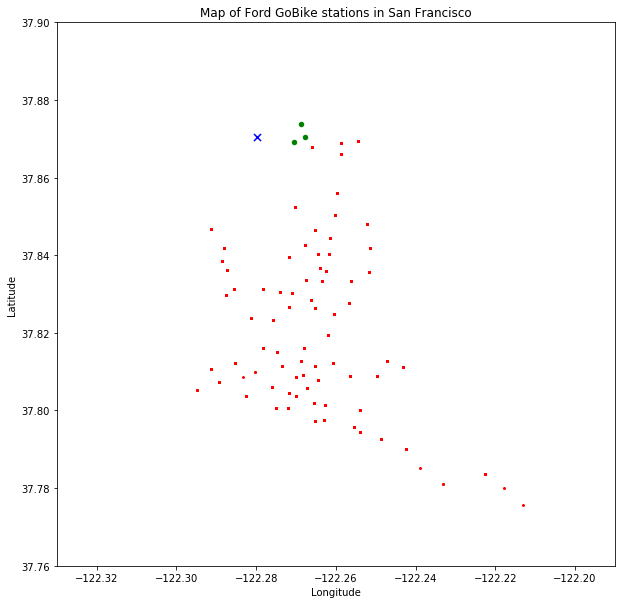

In [19]:
plt_neighbors(cdf, neighbors, id_coord2)

In [20]:
# t = 230
# print("The origin station is {}.".format(t))
# print("The 3 closest neighbors are: {}, {}, {}".format(int(neighbors.get(t)[0]),int(neighbors.get(t)[1]),int(neighbors.get(t)[2])))
# plt.figure(figsize = (10,10))
# ll,rr = -122.50, -122.36
# bb = 37.73
# plt.xlim(ll,rr)
# plt.ylim(bb, bb+(rr-ll))
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.title("Map of Ford GoBike stations in San Francisco")
# plt.scatter(qtr.end_station_longitude, qtr.end_station_latitude, s=1, c=('r'))
# plt.scatter(id_coord.get(t)[0], id_coord.get(t)[1], s=20, marker='x', c=('b'))

# for st in neighbors.get(t):
#     plt.scatter(id_coord.get(st)[0],id_coord.get(st)[1], s= 10, c='g')
# plt.show()



In [21]:
def plt_stn():
    row_sze = len(neighbors)
    col_sze = len(next(iter(neighbors.values())))
    rnge = row_sze*col_sze
    fig = plt.figure(figsize=(10,10))
    graph = 1
    for k, v in neighbors.items():
        num = 1
        for s_id in v:
            plt.subplot(rnge,1,graph)
            plt.subplots_adjust(top=10, bottom =5)
            plt.xlabel("days")
            plt.ylabel("trips per day")
            plt.title("This is station {}, and it is neighbor #{} for station {}".format(s_id, num, k))
            ts = days_count(qtr, s_id)
            plt.plot(ts[:,0],ts[:,1])
            num+=1
            graph+=1
            

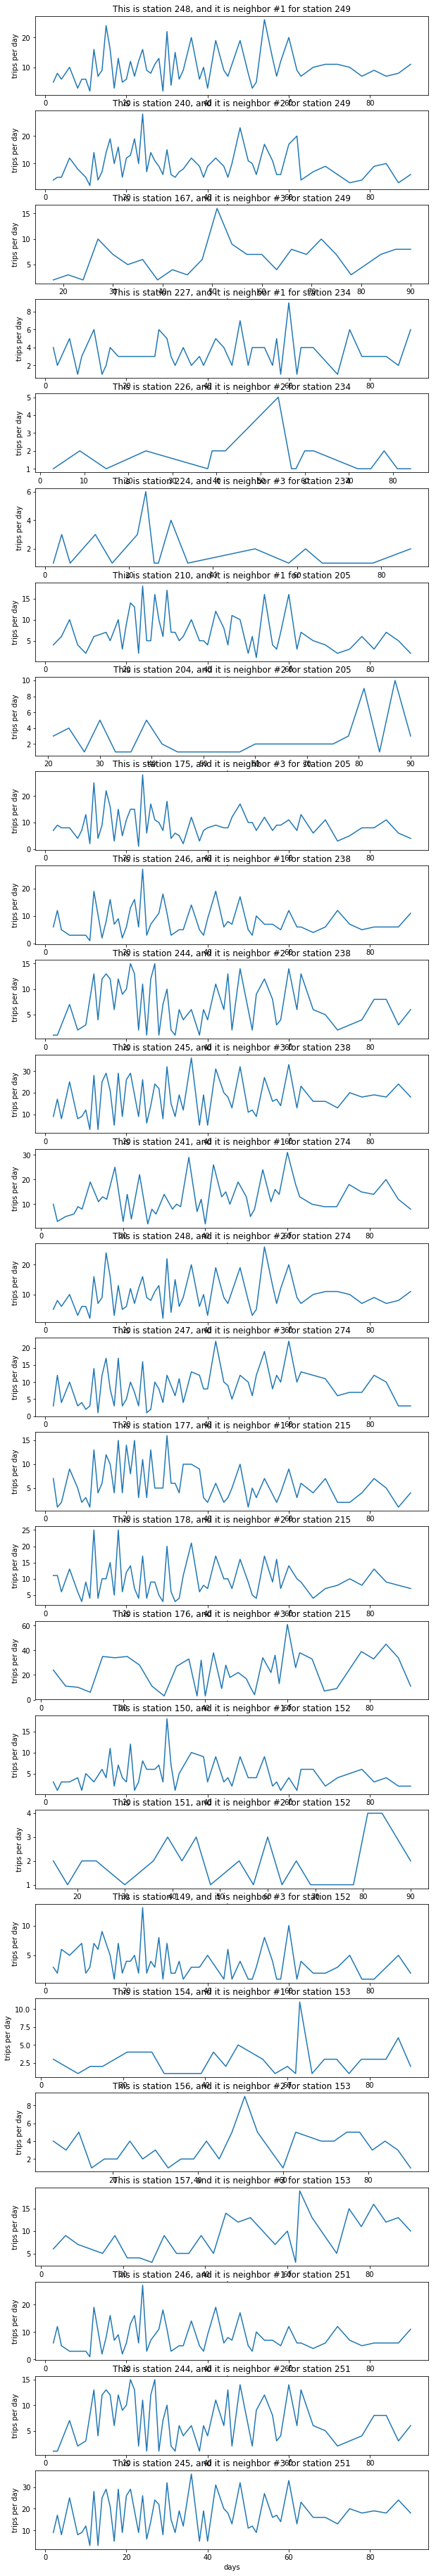

In [22]:
plt_stn()

## Testing Stations

In [23]:
neighbors


{249: [248, 240, 167],
 234: [227, 226, 224],
 205: [210, 204, 175],
 238: [246, 244, 245],
 274: [241, 248, 247],
 215: [177, 178, 176],
 152: [150, 151, 149],
 153: [154, 156, 157],
 251: [246, 244, 245]}

In [62]:
test_station=248

In [131]:
ts = days_count(qtr, test_station)

In [64]:
tseries = pd.Series(ts[:,1])

In [65]:
tseries.values

array([ 5,  8,  6, 10,  3,  6,  6,  2, 16,  7,  9, 24, 16,  3, 13,  5,  6,
       12,  7, 12, 16,  9,  8, 11, 13,  2, 22,  4, 15,  6,  9, 20,  6, 10,
        3, 19,  9,  7, 11, 19,  8,  3,  5, 26, 13,  7, 12, 20,  9,  7, 10,
       11, 11, 10,  7,  9,  7,  8, 11])

In [66]:
test = sm.tsa.stattools.adfuller(tseries)
print("ADF p-value: {0:2.2f}".format(test[1]))

ADF p-value: 0.00


In [67]:
tseries_diffed = tseries.diff()[1:]

In [68]:
sm.tsa.stattools.adfuller(tseries_diffed)[1]

4.242332037496074e-06

In [69]:
sm.tsa.stattools.adfuller(tseries_diffed)[1]>0.05

False

In [70]:
def stationary_convert(series, pvalue=0.05):
    test = sm.tsa.stattools.adfuller(series)
    if test[1] > pvalue:
        tseries_diffed = tseries.diff()[1:]
        return tseries_diffed
    return series

In [71]:
trip_vals = tseries.values
trip_vals

array([ 5,  8,  6, 10,  3,  6,  6,  2, 16,  7,  9, 24, 16,  3, 13,  5,  6,
       12,  7, 12, 16,  9,  8, 11, 13,  2, 22,  4, 15,  6,  9, 20,  6, 10,
        3, 19,  9,  7, 11, 19,  8,  3,  5, 26, 13,  7, 12, 20,  9,  7, 10,
       11, 11, 10,  7,  9,  7,  8, 11])

In [72]:
trip_model = ARIMA(trip_vals, order=(3, 1, 0)).fit()

In [73]:
predictions = trip_model.predict(75, 85, typ='levels')
predictions

array([8.34286863, 8.27082142, 9.24117686, 9.58743492, 8.66549305,
       8.98731106, 9.35692097, 9.25647411, 9.05164   , 9.2835792 ,
       9.37597942, 9.3105984 , 9.32068641, 9.43705701, 9.46054117,
       9.45976853, 9.50887517, 9.56757476, 9.58922474, 9.6180307 ,
       9.66433691, 9.70391737, 9.73358094, 9.77052739, 9.81091417,
       9.84658904, 9.88109702])

In [74]:
test = np.append(trip_vals, predictions)

In [75]:
test1 = pd.Series(test)

In [76]:
test1

0      5.000000
1      8.000000
2      6.000000
3     10.000000
4      3.000000
5      6.000000
6      6.000000
7      2.000000
8     16.000000
9      7.000000
10     9.000000
11    24.000000
12    16.000000
13     3.000000
14    13.000000
15     5.000000
16     6.000000
17    12.000000
18     7.000000
19    12.000000
20    16.000000
21     9.000000
22     8.000000
23    11.000000
24    13.000000
25     2.000000
26    22.000000
27     4.000000
28    15.000000
29     6.000000
        ...    
56     7.000000
57     8.000000
58    11.000000
59     8.342869
60     8.270821
61     9.241177
62     9.587435
63     8.665493
64     8.987311
65     9.356921
66     9.256474
67     9.051640
68     9.283579
69     9.375979
70     9.310598
71     9.320686
72     9.437057
73     9.460541
74     9.459769
75     9.508875
76     9.567575
77     9.589225
78     9.618031
79     9.664337
80     9.703917
81     9.733581
82     9.770527
83     9.810914
84     9.846589
85     9.881097
Length: 86, dtype: float

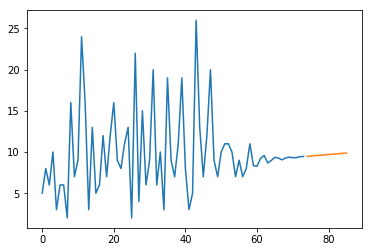

In [77]:
plt.plot(test1.index[0:74], test1[0:74])
plt.plot(test1.index[74:], test1[74:])


Observations: 31
Training Observations: 17
Testing Observations: 14
Observations: 45
Training Observations: 31
Testing Observations: 14
Observations: 59
Training Observations: 45
Testing Observations: 14


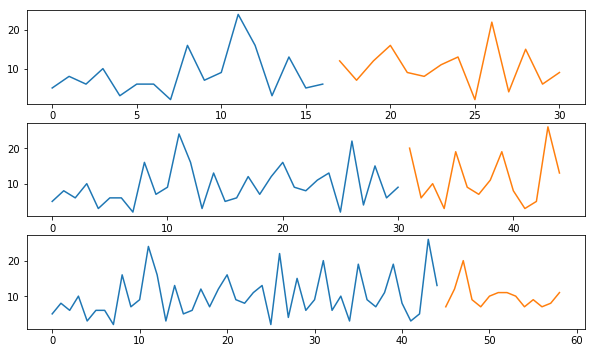

In [78]:
tseries = pd.Series(ts[:,1])
tscv = TimeSeriesSplit(n_splits=3)
fig = plt.figure(figsize=(10,10))
index = 1
for train_index, test_index in tscv.split(tseries):
    train = tseries[train_index]
    test = tseries[test_index]

    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    plt.subplot(5,1,index)
    plt.plot(train)
    plt.plot([None for i in train] + [x for x in test])
    index += 1
plt.show()

In [79]:
def ARIMA_pred(arr, p=3, d=1, q=1):
    tseries = pd.Series(arr[:,1])
#     tseries = stationary_convert(tseries)
    tscv = TimeSeriesSplit(n_splits=3)
    fig = plt.figure(figsize=(10,10))
    index = 1
    
    actual = []
    mean_mse= np.array([])
    for train_index, test_index in tscv.split(tseries):
        train = tseries[train_index]
        test = tseries[test_index]

        train_vals = train.values
        trip_model = ARIMA(train_vals, order=(p, d, q)).fit()
    
        train_sze = len(train)
        predictions = trip_model.predict(train_sze, train_sze+len(test)-1, typ='levels')
        
        #calculate mean squared error
        mse = mean_squared_error(predictions, np.array(test))
        mean_mse = np.append(mean_mse, mse)
        
        #combine to plot on same graph
        combined = np.append(train_vals, predictions)
        combined = pd.Series(combined)
        plt.subplot(3,1,index)
        plt.xlabel('Days')
        plt.ylabel('Trip Counts')
        plt.title('This has a mean squared error of {}'.format(mse))
        plt.plot(combined.index[:train_sze], combined[:train_sze], label="train")
        plt.plot(combined.index[train_sze:], combined[train_sze:], label='predicted')
#         plt.plot(test)


        print (np.array(test))
#         print(len(train_index))
#         print (test_index)
        print (predictions)
        
        index +=1
    avg_mse = mean_mse.mean()
    return avg_mse

[12  7 12 16  9  8 11 13  2 22  4 15  6  9]
[10.64725017  6.32556656  7.35994823  9.54930873  7.30219012  8.12771438
  9.16216353  8.04213713  8.6405888   9.1459048   8.62684479  9.04856364
  9.31962005  9.11559983]
[20  6 10  3 19  9  7 11 19  8  3  5 26 13]
[10.33845779  8.36742474  9.52702008  9.6004073   9.2846644   9.68365033
  9.69202934  9.71974757  9.88384681  9.93723688 10.02169757 10.12544369
 10.20257885 10.29240055]
[ 7 12 20  9  7 10 11 11 10  7  9  7  8 11]
[ 9.67497421 15.25870271 17.71534482 12.9683343  14.15842914 16.15603847
 15.64127043 14.73696996 15.77336823 16.16706446 15.8812427  16.00539676
 16.47894132 16.56448334]


36.93643104448263

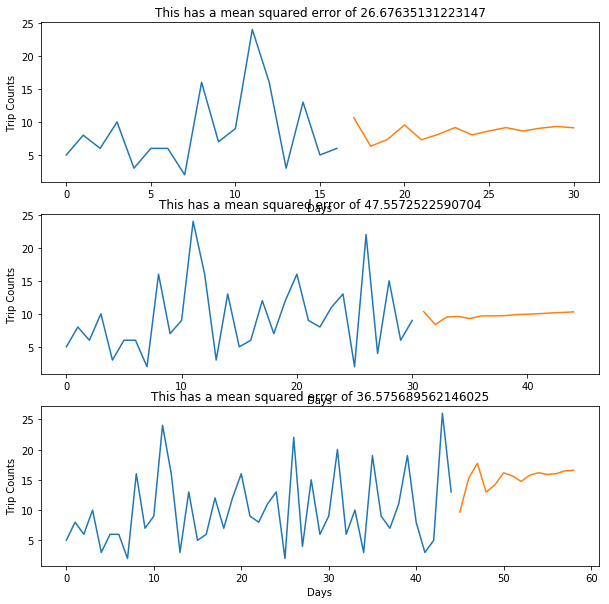

In [80]:
ARIMA_pred(ts,3,1,0)

In [147]:
def best_ARIMA_param(arr):
    max_param = 3
    q = 0
    score = np.array([0,0,0,0])
    for p in range(1,3+1):
        for d in range(1,3-1):
            mse = ARIMA_pred(arr, p, d, q)
            score_data = np.array([p,d,q,mse])
            score = np.vstack((score, score_data))
    print("This is the array of scores")
    return score[1:]

[12  7 12 16  9  8 11 13  2 22  4 15  6  9]
[5.5375814  5.72061366 5.6187707  5.64265984 5.61105605 5.60394454
 5.58602315 5.57287279 5.5576167  5.54328999 5.52855309 5.51399723
 5.49936147 5.48476097]
[20  6 10  3 19  9  7 11 19  8  3  5 26 13]
[7.20041288 8.42978722 7.74762057 8.27180434 8.03467494 8.27800109
 8.21811754 8.34958596 8.36029447 8.44721311 8.48603645 8.55521215
 8.60523284 8.66734203]
[ 7 12 20  9  7 10 11 11 10  7  9  7  8 11]
[20.95863528 16.77307301 19.62430164 18.39815702 19.53459115 19.302061
 19.86275867 19.96383122 20.33122732 20.54430585 20.84680161 21.09748576
 21.37819144 21.64150156]
[12  7 12 16  9  8 11 13  2 22  4 15  6  9]
[9.75320443 6.78388465 7.03679978 8.62755546 7.56575964 7.64121761
 8.33817745 7.9947473  8.04574813 8.37654037 8.30167143 8.36061194
 8.54259171 8.56732929]
[20  6 10  3 19  9  7 11 19  8  3  5 26 13]
[10.68100346  7.89007589  9.94878105  9.56021317  9.17128784  9.94861891
  9.62524221  9.78524677 10.01336192  9.94689429 10.12604669 10

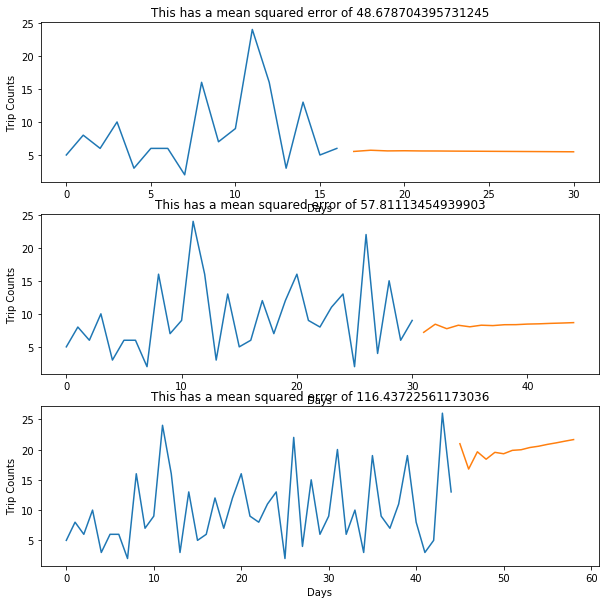

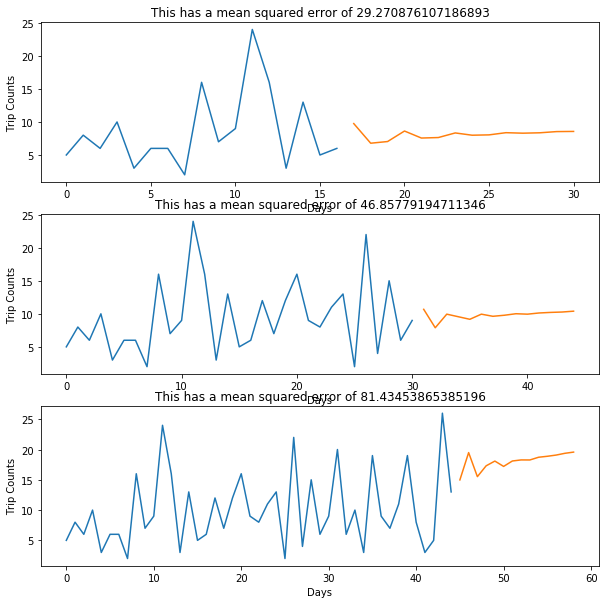

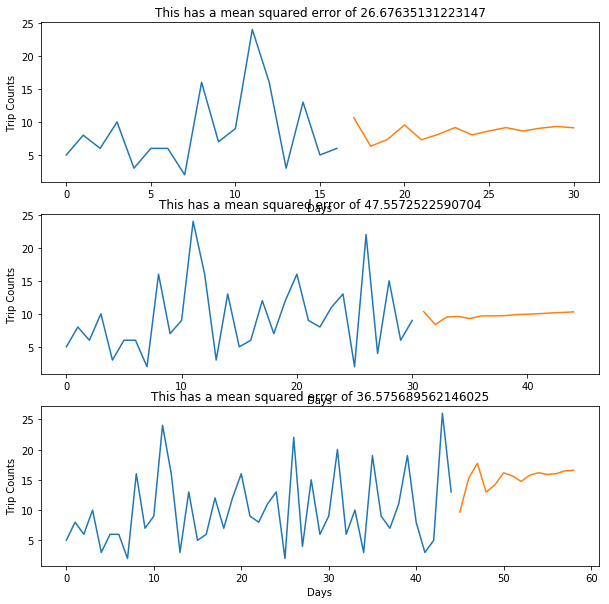

In [148]:
score = best_ARIMA_param(ts)

In [83]:
score

array([[ 1.        ,  1.        ,  0.        , 74.30902152],
       [ 2.        ,  1.        ,  0.        , 52.5210689 ],
       [ 3.        ,  1.        ,  0.        , 36.93643104]])

In [84]:
np.sort(score[:,3]).reshape(-1,1)

array([[36.93643104],
       [52.5210689 ],
       [74.30902152]])

In [85]:
np.sort(score[:,3]).reshape(-1,1)[0]

array([36.93643104])

In [86]:
score[:,3] ==np.sort(score[:,3]).reshape(-1,1)[0]

array([False, False,  True])

In [87]:
score[score[:,3] ==np.sort(score[:,3]).reshape(-1,1)[0]]

array([[ 3.        ,  1.        ,  0.        , 36.93643104]])

In [88]:
score[score[:,3] ==np.sort(score[:,3]).reshape(-1,1)[0]]

array([[ 3.        ,  1.        ,  0.        , 36.93643104]])

In [89]:
score

array([[ 1.        ,  1.        ,  0.        , 74.30902152],
       [ 2.        ,  1.        ,  0.        , 52.5210689 ],
       [ 3.        ,  1.        ,  0.        , 36.93643104]])

In [90]:
def best_params(score):
    best_params = score[score[:,3] ==np.sort(score[:,3]).reshape(-1,1)[0]]
    return best_params

In [91]:
b_params = best_params(score)

In [92]:
type(b_params[0][0])

numpy.float64

In [93]:
b_params[0][1]

1.0

In [94]:
b_params[0][2]

0.0

In [104]:
def forecast_nxt_30d(ts, b_params):
    tseries = pd.Series(ts[:,1])
    p = int(b_params[0][0])
    d = int(b_params[0][1])
    q = int(b_params[0][2])
    
    current_vals = tseries.values
    trip_model = ARIMA(current_vals, order=(p, d, q)).fit()

    train_sze = len(current_vals)
#     predictions = trip_model.predict(train_sze, train_sze+30, typ='levels')
    predictions = trip_model.predict(90, 120, typ='levels')

    #combine to plot on same graph
    combined = np.append(current_vals, predictions)
    combined = pd.Series(combined)
    plt.xlabel('Days')
    plt.ylabel('Trip Counts')
#     plt.title('This has a mean squared error of {}'.format(mse))
    plt.plot(combined.index[:train_sze], combined[:train_sze], label="train")
    plt.plot(combined.index[train_sze:], combined[train_sze:], label='predicted')
    
    next_month_avg_pred = np.round(predictions.mean(), decimals=2)
    return next_month_avg_pred

In [105]:
tseries = pd.Series(ts[:,1])
current_vals= tseries.values
current_vals

array([ 5,  8,  6, 10,  3,  6,  6,  2, 16,  7,  9, 24, 16,  3, 13,  5,  6,
       12,  7, 12, 16,  9,  8, 11, 13,  2, 22,  4, 15,  6,  9, 20,  6, 10,
        3, 19,  9,  7, 11, 19,  8,  3,  5, 26, 13,  7, 12, 20,  9,  7, 10,
       11, 11, 10,  7,  9,  7,  8, 11])

10.03

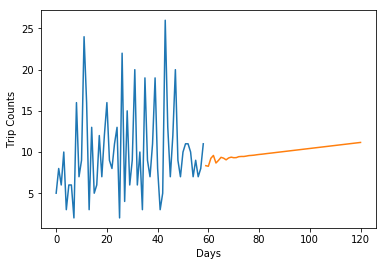

In [106]:
forcast_nxt_30d(ts, b_params)

In [107]:
ndf.head(2)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,member_gender,bike_share_for_all_trip,day_of_week,date,year,month,day,hour,malfunction,age
2421046,46640,2017-10-31 18:59:54.611,2017-11-01 07:57:15.3990,211.0,Broadway at 40th St,37.827757,-122.256716,195.0,Bay Pl at Vernon St,37.812314,...,NaN,NaN,1,2017-10-31,2017,10,31,18,False,NaN
2421372,1877,2017-10-31 23:38:24.594,2017-11-01 00:09:41.8450,180.0,Telegraph Ave at 23rd St,37.812678,-122.268773,205.0,Shafter Ave at Cavour St,37.837947,...,NaN,NaN,1,2017-10-31,2017,10,31,23,False,NaN


In [108]:
val_df = ndf[ndf.end_station_id == test_station]

In [109]:
count = val_df.day.value_counts()

In [110]:
actual_trips_per_day = np.array(count).mean()

In [111]:
actual_trips_per_day

8.161290322580646

## apply predictions to neighbor statoins

In [153]:
def ready_set_go(qtr,cdf,neighbors):
    #stores the proposed location's stations id and its neighbors' overall average trip count per day
    trend = {}
    #get the orgin station and its neighbor
    for k, v in neighbors.items():
        
        avg_temp = []
        #access each neighbor for station k
        for s in v:
            
            print ("This is station {}, and the neighbor is {}".format(k,s))
            
            #time series data for station s
            ts = days_count(qtr,s)
            
            #scores for each ARIMA hyper parameter combination
            score = best_ARIMA_param(ts)
            
            #best hyper parameter for the model
            #based on smallest MSE
            b_params = best_params(score)
            
            #average prediction of trips per day for the next month
            avg_pred = forecast_nxt_30d(ts, b_params)
            avg_temp.append(s)
        neigh_avg = np.array(avg_temp).mean()
        trend[k] = neigh_avg
            
    return trend

This is station 249, and the neighbor is 248
[12  7 12 16  9  8 11 13  2 22  4 15  6  9]
[5.5375814  5.72061366 5.6187707  5.64265984 5.61105605 5.60394454
 5.58602315 5.57287279 5.5576167  5.54328999 5.52855309 5.51399723
 5.49936147 5.48476097]
[20  6 10  3 19  9  7 11 19  8  3  5 26 13]
[7.20041288 8.42978722 7.74762057 8.27180434 8.03467494 8.27800109
 8.21811754 8.34958596 8.36029447 8.44721311 8.48603645 8.55521215
 8.60523284 8.66734203]
[ 7 12 20  9  7 10 11 11 10  7  9  7  8 11]
[20.95863528 16.77307301 19.62430164 18.39815702 19.53459115 19.302061
 19.86275867 19.96383122 20.33122732 20.54430585 20.84680161 21.09748576
 21.37819144 21.64150156]
[12  7 12 16  9  8 11 13  2 22  4 15  6  9]
[9.75320443 6.78388465 7.03679978 8.62755546 7.56575964 7.64121761
 8.33817745 7.9947473  8.04574813 8.37654037 8.30167143 8.36061194
 8.54259171 8.56732929]
[20  6 10  3 19  9  7 11 19  8  3  5 26 13]
[10.68100346  7.89007589  9.94878105  9.56021317  9.17128784  9.94861891
  9.62524221  9.78

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:620: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:622: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


[ 2  4  3  6 16  9]
[13.26681291 10.64009956  8.81041939  9.81416176 16.56482021 14.27624924]
[ 7  7  4  8  7 10]
[12.67764467 15.58754393 13.37862843 16.07140877 17.10207821 16.99670736]
[7 3 5 7 8 8]
[ 9.72132057  9.91450345 10.52266419 10.88275105 11.26340078 11.68149184]
This is the array of scores
This is station 234, and the neighbor is 227
[3 3 3 6 5 3 2 4 2 3 2]
[2.94803658 2.91719489 2.87776778 2.84183042 2.80447457 2.76769529
 2.73068165 2.69376328 2.65680618 2.61986482 2.58291707]
[3 5 4 2 7 2 4 4 2 5 1]
[2.32137613 2.12344784 2.12960761 2.05556021 2.01303445 1.95812059
 1.90807529 1.85611664 1.80490994 1.75340772 1.70202164]
[9 1 4 4 1 6 3 3 3 2 6]
[3.26156131 1.92290199 2.65426769 2.19542755 2.42092211 2.25294358
 2.31120094 2.23937906 2.24234907 2.20231585 2.18700828]
[3 3 3 6 5 3 2 4 2 3 2]
[3.52545253 3.20546205 3.15426926 3.36452594 3.27110481 3.23705165
 3.32054881 3.29895209 3.28405762 3.31864487 3.318346  ]
[3 5 4 2 7 2 4 4 2 5 1]
[2.03789009 2.37221396 2.0786393  2

/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1284: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

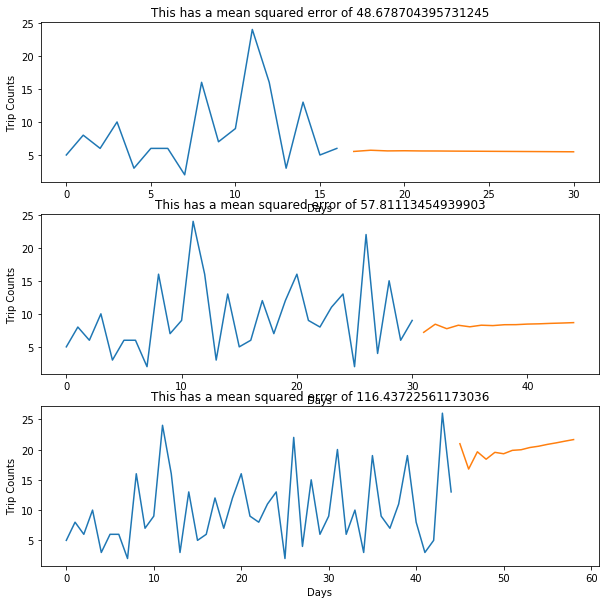

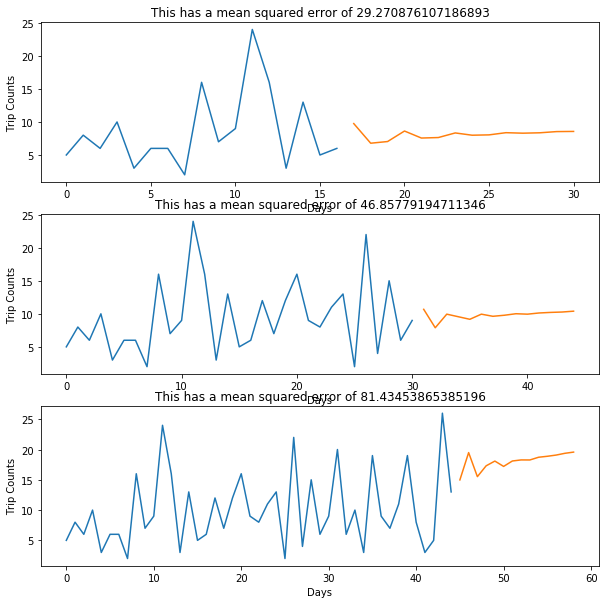

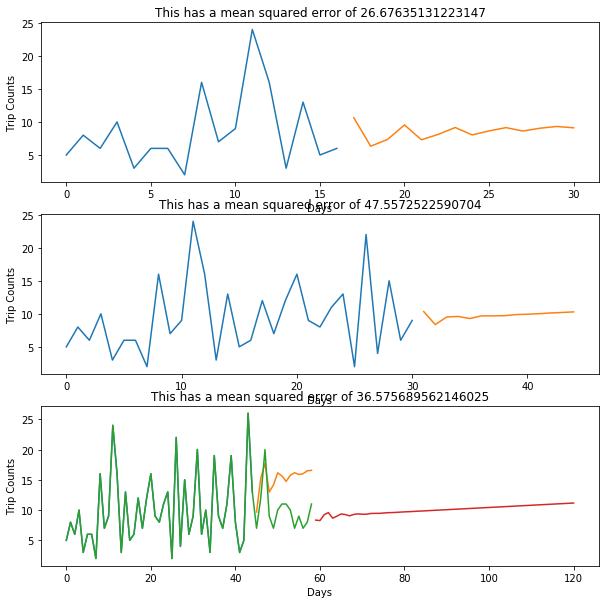

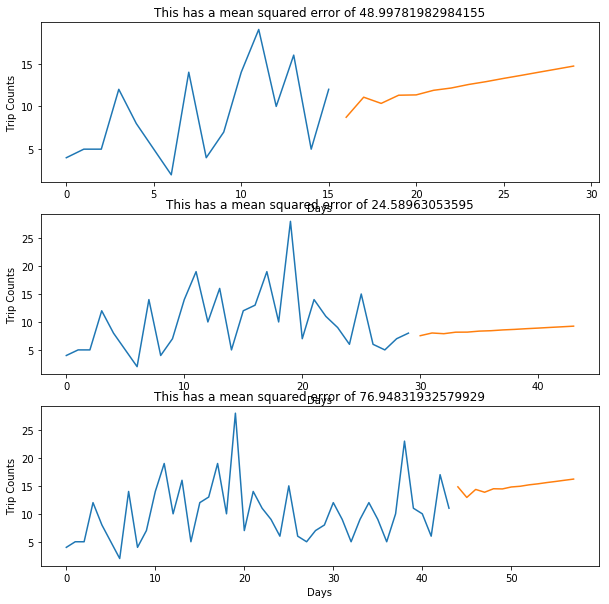

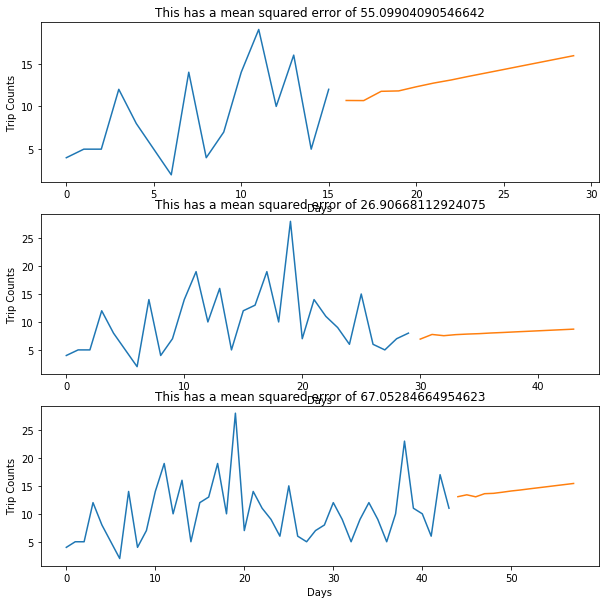

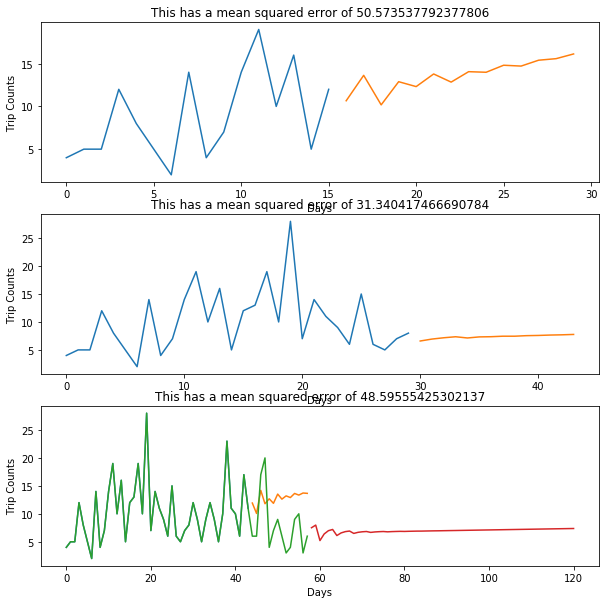

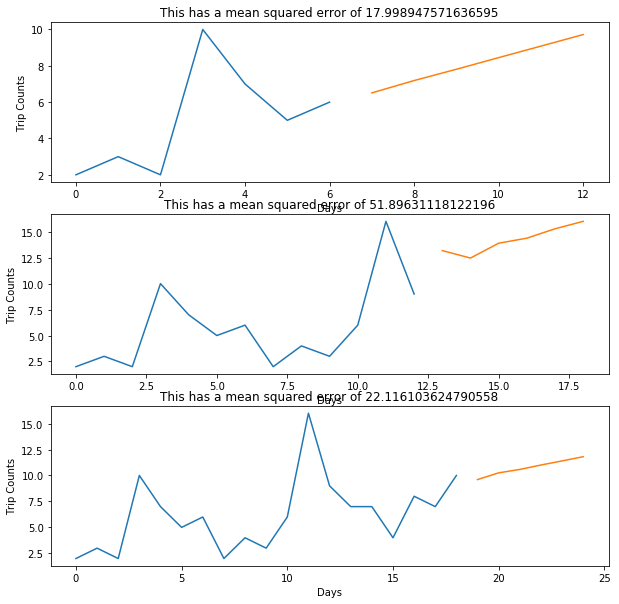

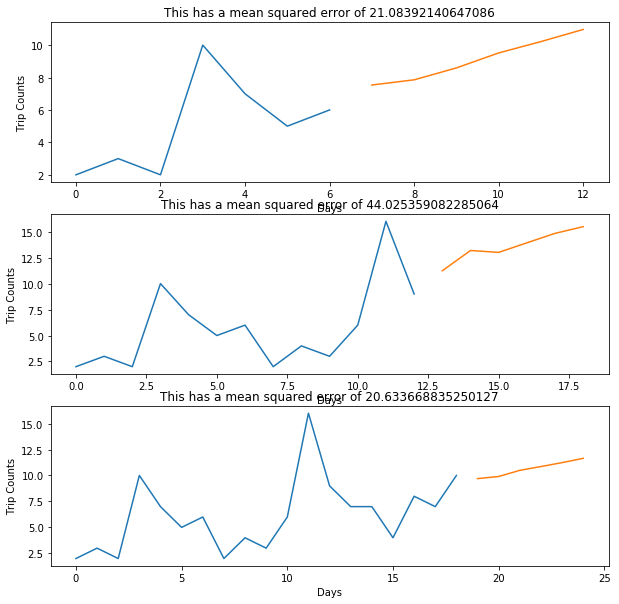

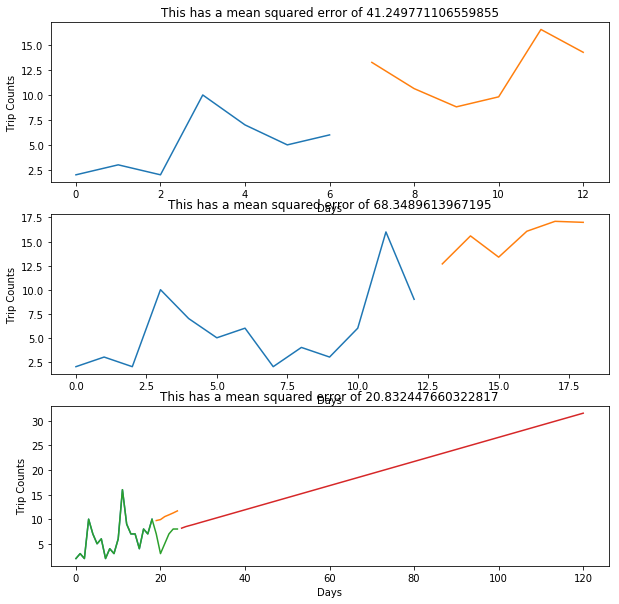

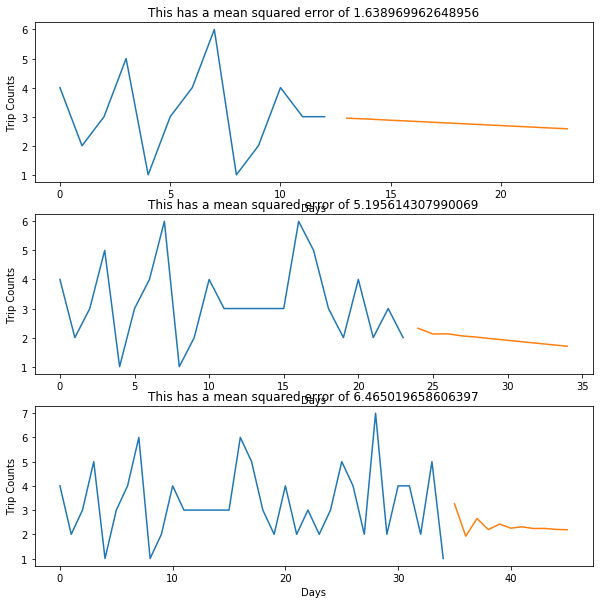

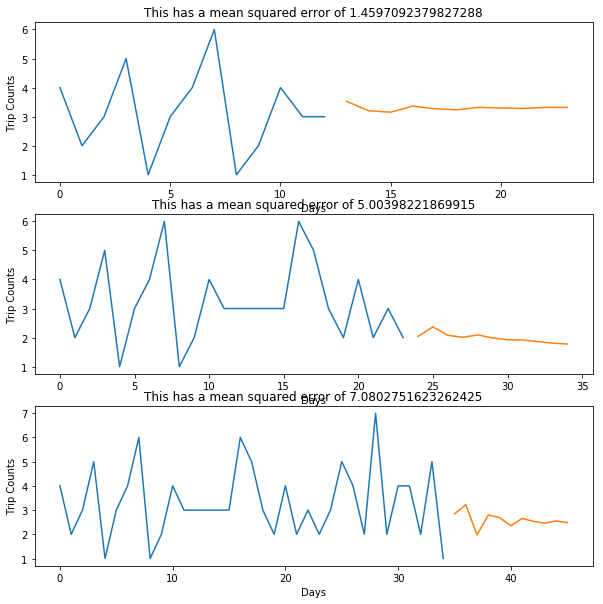

<Figure size 720x720 with 0 Axes>

In [158]:
trend = ready_set_go(qtr,cdf, neighbors)

In [ ]:
ready_set_go()

In [ ]:
samp_dict = {}

In [ ]:
samp_dict[[1,2,3]] = 2

In [ ]:
# #Print MSE to see how good the model is
# Error = mean_squared_error(TestData, Predictions)
# print('Test Mean Squared Error (smaller the better fit): %.3f' % Error)
# # plot
# pyplot.plot(TestData)
# pyplot.plot(Predictions, color='red')
# pyplot.show()

In [ ]:
# #in a for loop, predict values using ARIMA model
# for timepoint in range(len(TestData)):
#     ActualValue =  TestData[timepoint]
#     #forcast value
#     Prediction = StartARIMAForecasting(Actual, 3,1,0)    
#     print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
#     Predictions.append(Prediction)
#     Actual.append(ActualValue)